In [ ]:
# Importing libraries and getting access to google drive
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, jaccard_score
from tqdm import tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining path of dataset
base_path = '/content/drive/MyDrive/Binary masks'

train_image_path = os.path.join(base_path, 'train/images')
train_mask_path = os.path.join(base_path, 'train/masks')

valid_image_path = os.path.join(base_path, 'valid/images')
valid_mask_path = os.path.join(base_path, 'valid/masks')

test_image_path = os.path.join(base_path, 'test/images')
test_mask_path = os.path.join(base_path, 'test/masks')

In [ ]:
# Setting Image Size, Batch Size and Number of Epochs
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
EPOCHS = 20

In [ ]:
# Defining function to calculate dice loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
# Defining function to calculate IOU loss
def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

In [ ]:
# Loading dataset and preprocessing images for training on U-Net
def load_dataset(image_dir, mask_dir):
    images = []
    masks = []

    for img_filename in sorted(os.listdir(image_dir)):
        # Construct full path for image
        image_path = os.path.join(image_dir, img_filename)

        # Construct corresponding mask filename
        base_name = os.path.splitext(img_filename)[0]
        mask_filename = f"{base_name}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        # Skip if corresponding mask not found
        if not os.path.exists(mask_path):
            print(f"Mask not found for image: {img_filename}")
            continue

        # Read and process image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0

        # Read and process mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 127).astype(np.float32)

        images.append(img)
        masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)

In [ ]:
# Defining U-Net model
def build_unet():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # Encoder

    # Block 1
    c1 = layers.Conv2D(64, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    c1 = layers.Conv2D(64, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)

    p1 = layers.MaxPooling2D()(c1)

    # Block 2
    c2 = layers.Conv2D(128, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)

    c2 = layers.Conv2D(128, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)

    p2 = layers.MaxPooling2D()(c2)

    # Block 3
    c3 = layers.Conv2D(256, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)

    c3 = layers.Conv2D(256, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)

    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    b = layers.Conv2D(512, 3, padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)

    b = layers.Conv2D(512, 3, padding='same')(b)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)


    # Decoder
    # Decoder Block 1 (upsampling from bottleneck)
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])

    c4 = layers.Conv2D(256, 3, padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    c4 = layers.Conv2D(256, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)

    # Decoder Block 2
    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])

    c5 = layers.Conv2D(128, 3, padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    c5 = layers.Conv2D(128, 3, padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)

    # Decoder Block 3
    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])

    c6 = layers.Conv2D(64, 3, padding='same')(u1)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    c6 = layers.Conv2D(64, 3, padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    # Output Layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,iou_coef])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_16[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_19[0][0] 

 Total params: 7,794,177 (29.73 MB)

 Trainable params: 7,788,545 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
train_images, train_masks = load_dataset(train_image_path, train_mask_path)
valid_images, valid_masks = load_dataset(valid_image_path, valid_mask_path)
test_images, test_masks = load_dataset(test_image_path, test_mask_path)

In [ ]:
# Train the U-Net
history = model.fit(
    train_images, train_masks,
    validation_data=(valid_images, valid_masks),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 88s 608ms/step - accuracy: 0.8430 - dice_coef: 0.6515 - iou_coef: 0.6043 - loss: 0.3666 - val_accuracy: 0.7657 - val_dice_coef: 0.4180 - val_iou_coef: 0.2315 - val_loss: 0.5208
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 423ms/step - accuracy: 0.9284 - dice_coef: 0.8156 - iou_coef: 0.7845 - loss: 0.1842 - val_accuracy: 0.7027 - val_dice_coef: 0.3602 - val_iou_coef: 5.9131e-05 - val_loss: 0.4966
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.9245 - dice_coef: 0.8083 - iou_coef: 0.7771 - loss: 0.1861 - val_accuracy: 0.7027 - val_dice_coef: 0.0052 - val_iou_coef: 5.9131e-05 - val_loss: 1.8596
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 433ms/step - accuracy: 0.9415 - dice_coef: 0.8488 - iou_coef: 0.8196 - loss: 0.1507 - val_accuracy: 0.7115 - val_dice_coef: 0.1591 - val_iou_coef: 0.0286 - val_loss: 1.0345
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 40s 422ms/step - accuracy: 0.9506 - dice_coef: 0.8725 - iou_coef: 0.8476 - loss: 0.1281 - val_

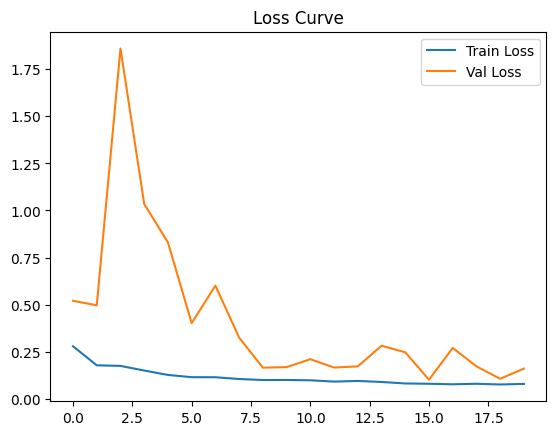

In [ ]:
# Plot train loss vs validaion loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [ ]:
# Displaying accuracy and IOU on test data
preds = model.predict(test_images)
preds = (preds > 0.5).astype(np.uint8)

# Flatten arrays for metric calculation
y_true = test_masks.flatten()
y_pred = preds.flatten()

acc = accuracy_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test IoU: {iou:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 54s 21s/step
Test Accuracy: 0.9412
Test IoU: 0.8091


In [ ]:
# Saving the model in google drive
model_dir = "/content/drive/MyDrive/tf_models"
import os
os.makedirs(model_dir, exist_ok=True)
model.save(os.path.join(model_dir, 'Dental_mkII.h5'))
model.save(os.path.join(model_dir, 'Dental_mkII.keras'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


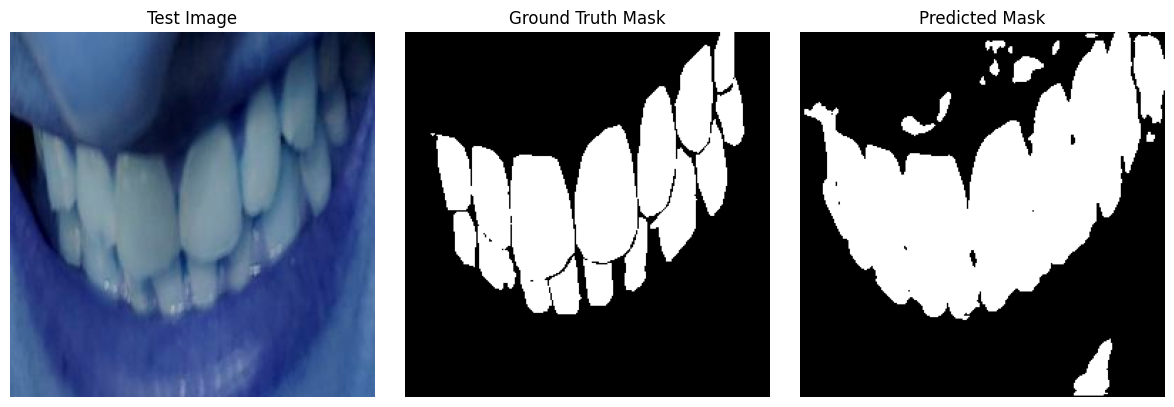

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


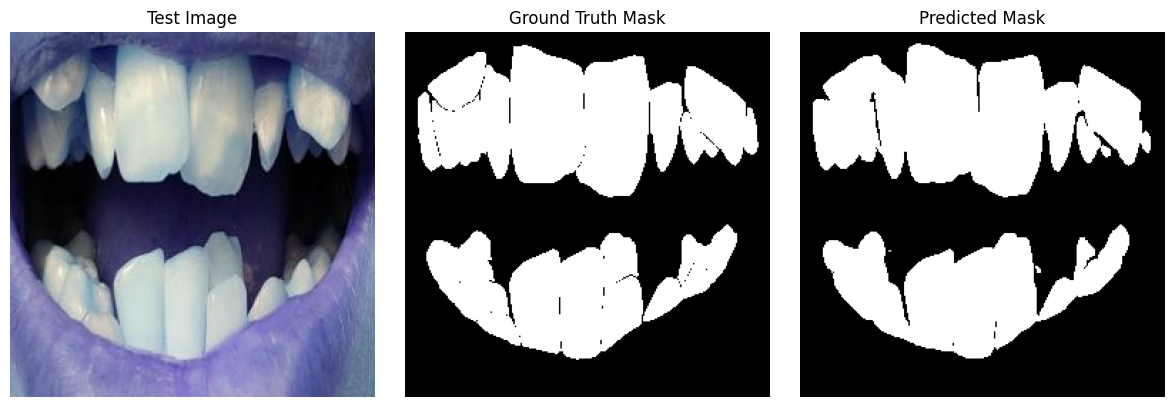

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


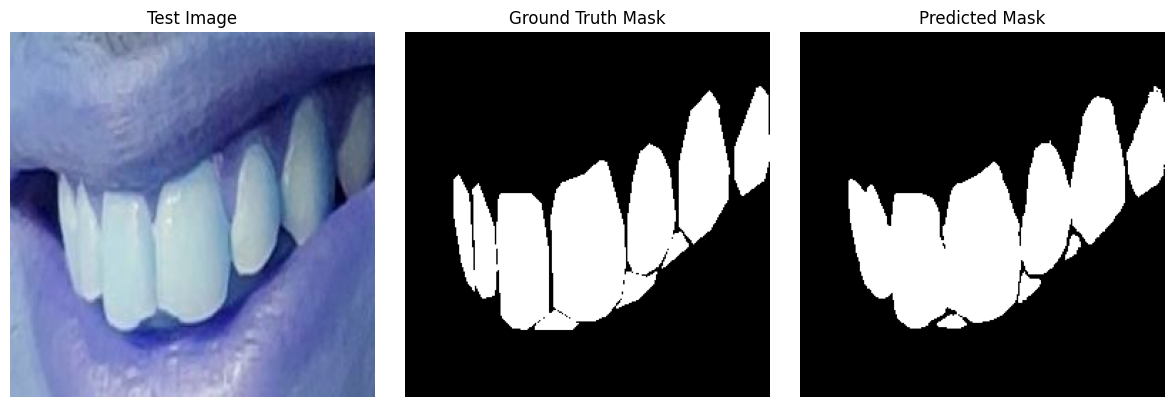

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


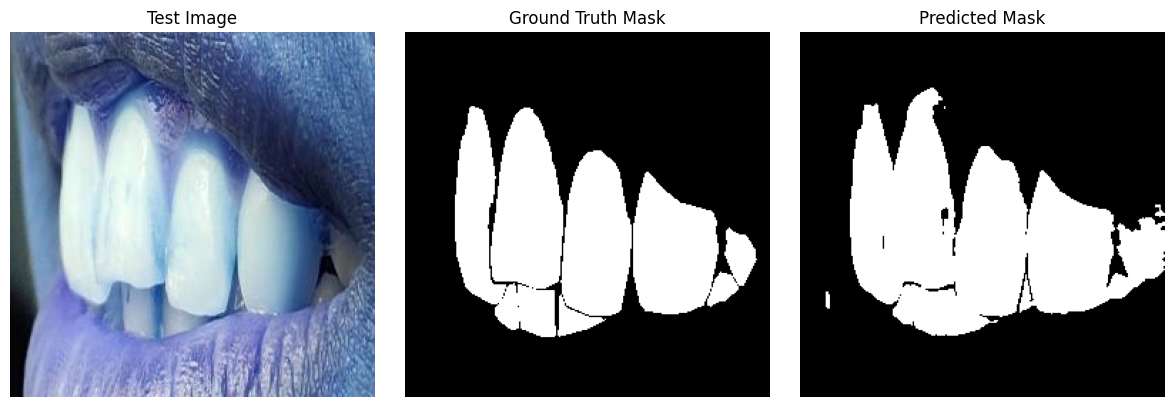

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


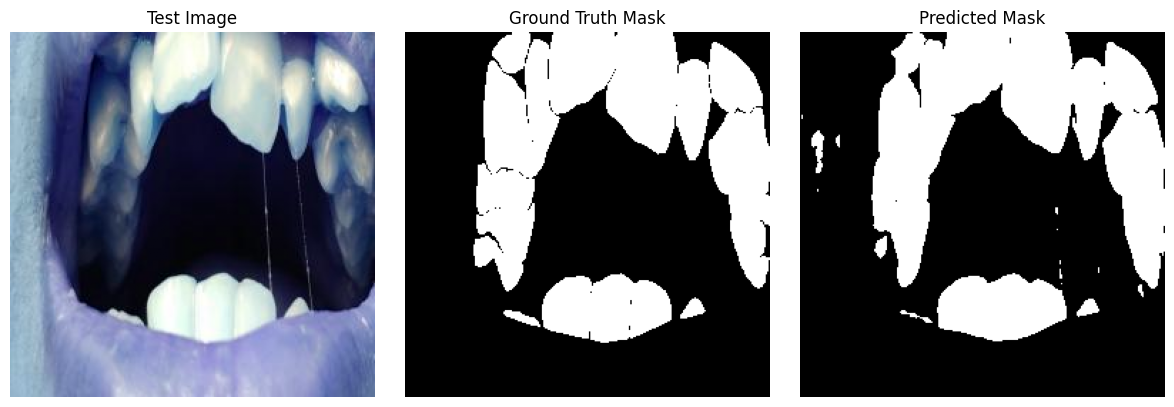

In [ ]:
import random
# Display 5 random images of actual masks and predicted masks
def display_predictions(model, test_images, test_masks, num_samples=5):
    indices = random.sample(range(len(test_images)), num_samples)

    for i in indices:
        image = test_images[i]
        true_mask = test_masks[i].squeeze()
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0].squeeze()

        # Threshold the predicted mask
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Test Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Show predictions
display_predictions(model, test_images, test_masks, num_samples=5)
